# Anomaly Detection

**Anomaly detection** is the identification of rare items, events, or observations that raise suspicions by differing significantly from the majority of the data. Typically the anomalous items will translate to some kind of problem such as credit card fraud, network intrusion, medical diagnostic, system health monitor.

Anomaly detection works on two basic premise:
- Anomalies only occur very rarely in the data.
- Their features differ from normal instances significantly.

Some techniques for detecting anomalies are given below.

## Interquartile Range (IQR)
<hr>
The simplest approach to identifying irregularities in data is to flag the data points that deviate from common statistical properties of distribution, including mean, median, mode, and quartiles.

One of the most popular ways is the Interquartile Range (IQR). IQR is a concept in statistics that is used to measure the statistical dispersion and data variability by dividing the dataset into quartiles.

In simple words, any dataset or any set of observations is divided into four defined intervals based upon the values of the data and how they compare to the entire dataset. A quartile is what divides the data into three points and four intervals.

<br>
<div style="align:center">
    <img src="media/five_stats.png" width=500>
</div>

Interquartile Range (IQR) is important because it is used to define the outliers. It is the difference between the third quartile and the first quartile $(IQR = Q3 - Q1)$. Outliers, in this case, are defined as the observations that are below $(Q1 - 1.5 \times IQR)$ or above $(Q3 + 1.5 \times IQR)$.

<br>
<div style="align:center">
    <img src="media/iqr.png" width=800>
</div>

### Implementation
```python
q75, q25 = np.percentile(x, [75 ,25])
iqr = q75 - q25
```

IQR technique doesn't work in the following scenarios
- The pattern is based on seasonality. This involves more sophisticated methods, such as decomposing the data into multiple trends to identify the change in seasonality.
- The definition of abnormal or normal may frequently change, as malicious adversaries constantly adapt themselves


## Isolation Forest
<hr>
Isolation Forest is an unsupervised machine learning algorithm for anomaly detection that operates fundamentally differently from conventional methods. Traditional techniques focus on establishing the normal data regions and then flagging data points outside these regions as outliers. In contrast, Isolation Forest focuses on isolating anomalies directly by assigning a score to each data point based on how easily it can be separated from the rest.

It employs a strategy of 'isolation' by randomly selecting features and then randomly creating splits within the range of these features. Anomalies, being few and distinct, are expected to be isolated closer to the root of the tree, resulting in shorter path lengths in this tree structure.

An ensemble of such trees makes up the Isolation Forest, where the average path length to isolate a sample serves as an indicator of normality. Samples with consistently shorter path lengths across the forest are deemed to be anomalies.

Isolation Forest is particularly effective with high-dimensional datasets and stands out for its efficiency in detecting anomalies.

<br>

<div style="align:center">
    <img src="media/isolation_forest.png" width=600>
</div>


In [1]:
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

[Scikit-Learn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

In [2]:
matplotlib.rcParams["contour.negative_linestyle"] = "solid"

In [3]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [4]:
# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation to give similar results to the OneClassSVM
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction, random_state=42)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    ("One-Class SVM (SGD)", make_pipeline(
        Nystroem(gamma=0.1, random_state=42, n_components=150),
        SGDOneClassSVM(
            nu=outliers_fraction,
            shuffle=True,
            fit_intercept=True,
            random_state=42,
            tol=1e-6,
        ),
    )),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))
]

In [5]:
# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

In [6]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

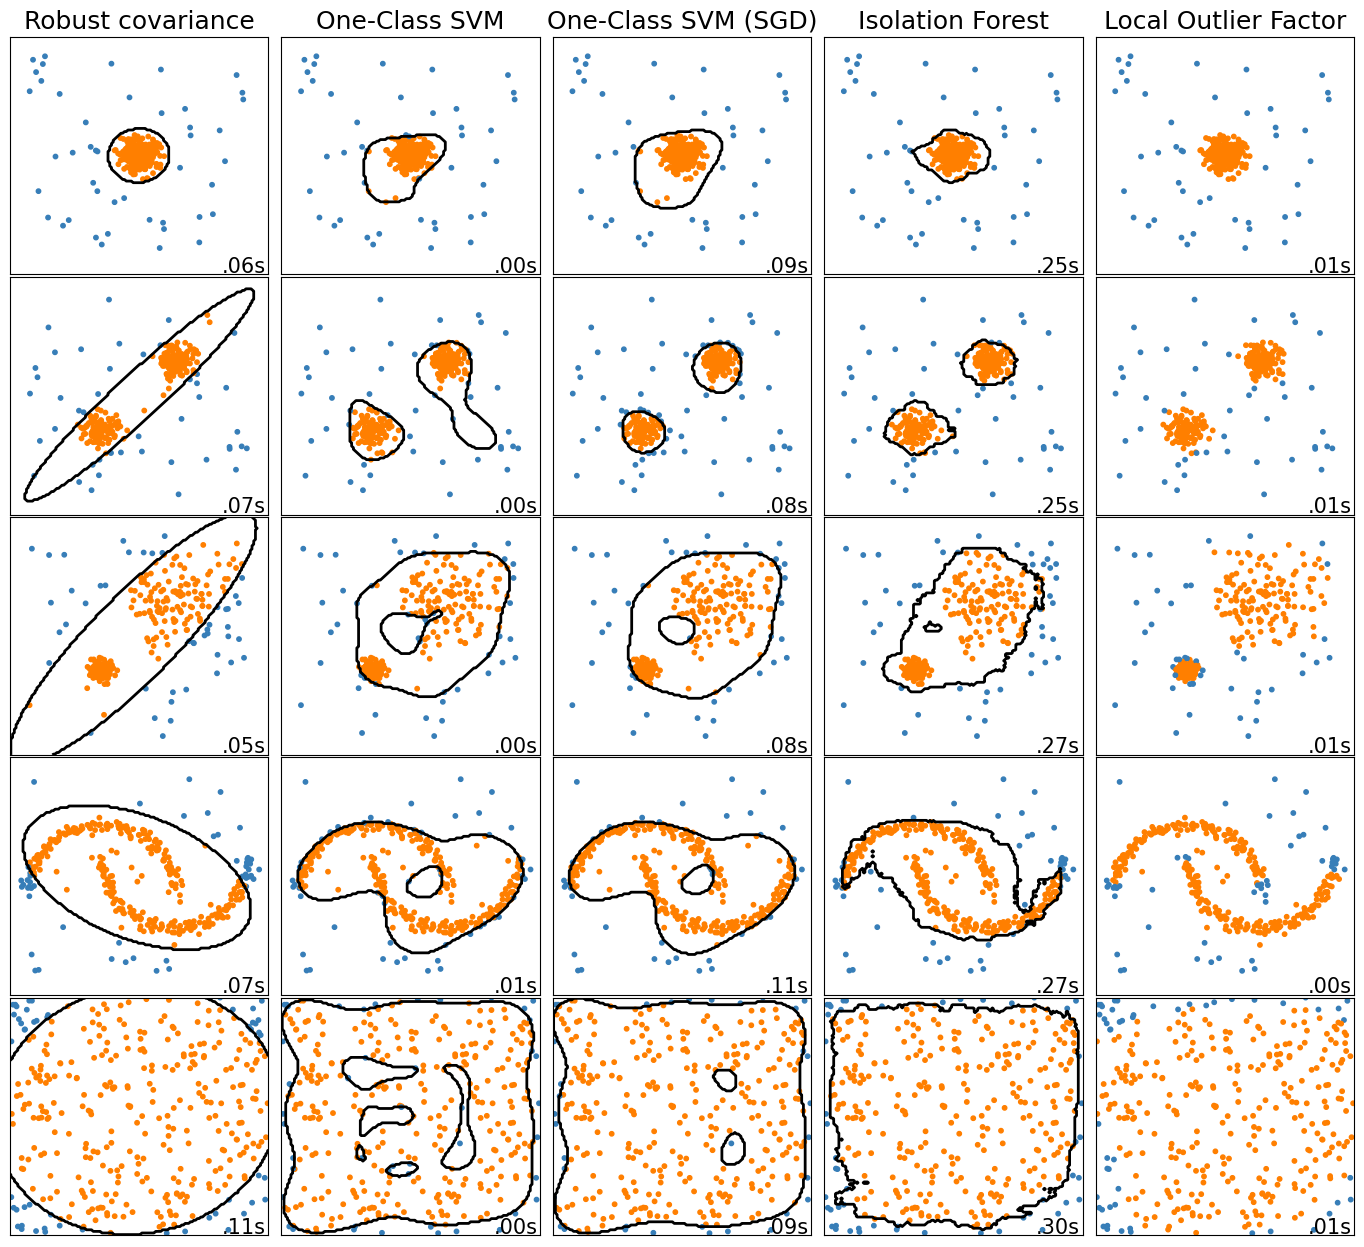

In [7]:
plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

<br>

## Credit Card Fraud Detection
<hr>

[Kaggle Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

**Context:** It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content:** The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [8]:
import pandas as pd
import seaborn as sns

pd.set_option("display.float", "{:.2f}".format)
sns.set_style("whitegrid")

%matplotlib inline

In [9]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [10]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Time feature exploration
The dataset contains a time column (in seconds) which could potentially influence how we approach the problem. There appears to be no visual relationship in the time distributions between fraudulent and non-fraudulent transactions.

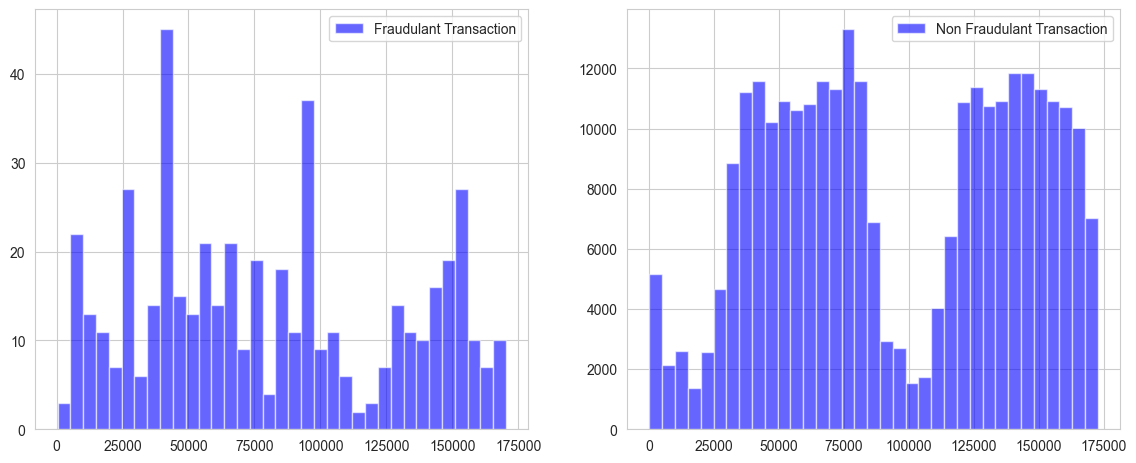

In [11]:
plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()
plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

### Use PCA to try and visualize abnormalities
Using PCA we can visualize high-dimensional problems in a lower dimensional plane. From the scatter matrix we can see that the anomalies are tending to occupying specific regions within the scatters especially for components PC1 vs PC3. What we would want to see at the end of this exercise is that the isolation forest identifies similar regions once trained.

In [12]:
# import plotly.express as px
# from sklearn.decomposition import PCA

# n_components=3
# pca = PCA(n_components=n_components)
# components = pca.fit_transform(data)
# total_var = pca.explained_variance_ratio_.sum() * 100

# labels = {str(i): f"PC {i+1}" for i in range(n_components)}

# labels['color'] = 'Class'

# fig = px.scatter_matrix(
#     components,
#     color=data['Class'],
#     dimensions=range(n_components),
#     labels=labels,
#     title=f'Total Explained Variance: {total_var:.2f}%',
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

In [13]:
X = data.drop('Class', axis=1)
y = data.Class

In [14]:
from sklearn.ensemble import IsolationForest

Iforest = IsolationForest(max_samples=100, random_state=48, contamination=0.05, max_features=1.0, 
                          n_estimators=100, verbose=1, n_jobs=-1)
Iforest.fit(X)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.4s remaining:    3.6s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.5s finished


IsolationForest(contamination=0.05, max_samples=100, n_jobs=-1, random_state=48,
                verbose=1)

In [15]:
y_pred = Iforest.predict(X)
y_pred_adjusted = [1 if x == -1 else 0 for x in y_pred]
sum(y_pred_adjusted)

14241

The algorithm identified `14241` data points as abnormal (approx 5%) which corresponds exactly with the contamination input parameter initially specified.

### Evaluation
Given that we are focused on anomaly detection it is important to measure algorithm effectiveness based on precision or recall rather than accuracy.

In [16]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y, y_pred_adjusted, average='macro')

(0.5144652695671054, 0.8984514055963063, 0.5157098237378664, None)

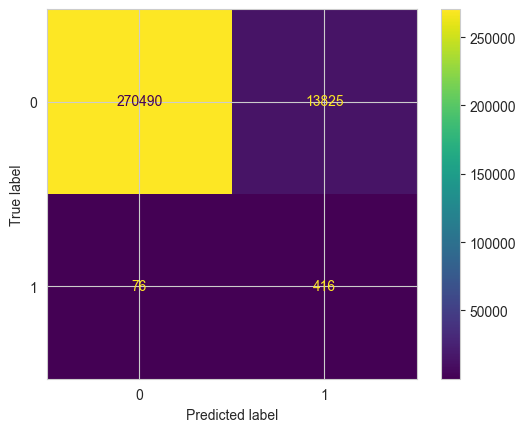

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

From the confusion matrix, the model falsely predicts a large proportion of the values to be abnormalities, despite this not being the case according to the labels.